In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arrow
from scipy.signal import savgol_filter 
import numpy as np
from lmfit.models import SkewedGaussianModel

In [2]:
# data from: http://ncov.mohw.go.kr/
df = pd.read_csv("all.csv").loc[1:].reset_index()
df["counts"] = [float(c.replace(",", "")) for c in df["계(명)"]]
df["savgol"] = savgol_filter([float(c.replace(",", "")) for c in df["계(명)"]], 7, 2)
df["ts"] = pd.to_datetime([str(arrow.get(t)) for t in df["일자"]])
df["rolling_avg"] = df["counts"].rolling(7).mean()
df.tail()

,index,일자,계(명),계(명).1,해외유입(명),사망(명),counts,savgol,ts,rolling_avg
804,805,2022.4.4,"127,190","127,184",6,218,127190.0,215912.142857,2022-04-04 00:00:00+00:00,285548.857143
805,806,2022.4.5,"266,135","266,108",27,209,266135.0,227724.000000,2022-04-05 00:00:00+00:00,273922.000000
806,807,2022.4.6,"286,294","286,272",22,371,286294.0,226931.285714,2022-04-06 00:00:00+00:00,254158.142857
807,808,2022.4.7,"224,820","224,780",40,348,224820.0,227151.142857,2022-04-07 00:00:00+00:00,240454.857143
808,809,2022.4.8,"205,333","205,325",8,373,205333.0,228383.571429,2022-04-08 00:00:00+00:00,229749.142857


In [3]:
def skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=False, weighted=False):
    """
    Parameters
    ----------
    target_y: univariate series to fit. 
    start_idx: start index
    df: whole dataframe
    show_stats: bool for plotting figs.
    weighted=False: bool for weighted fitting. If True, more recent data points get more weights on fitting. 
    
    """
    window_length = len(df) - start_idx
    april = pd.to_datetime([f"2022-04-{x}T00:00:00+00:00'" for x in range(1,31)]).to_list()
    may = pd.to_datetime([f"2022-05-{x}T00:00:00+00:00'" for x in range(1,32)]).to_list()
    whole_date = df["ts"].to_list() + april + may

    whole_date = sorted(list(set(whole_date)))
    xvals = np.arange(0, window_length)
    yvals = target_y[start_idx:]

    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=13639305., center=102.12, sigma=22.41, gamma=0)

    # adjust parameters  to best fit data.
    if weighted:
        result = model.fit(yvals, params, x=xvals, weights=xvals + 50)
    else:
        result = model.fit(yvals, params, x=xvals)
    
    if show_stats:
        print(result.fit_report())

    plt.figure(figsize=(6.5, 3))
    plt.title("fitting")
    plt.plot(xvals, yvals, 'd')
    ex = result.eval(x=xvals)
    plt.plot(xvals, ex)


    plt.figure(figsize=(8, 3))

    expected = result.eval(x=np.arange(-20, window_length+35))

    plt.plot(whole_date[start_idx-20:start_idx+window_length],  target_y[start_idx-20:], 'd', label="daily Covid cases")
    plt.plot(whole_date[start_idx-20:start_idx+window_length+35], expected, label="skewed gaussian fitting")
    plt.legend()
    plt.title("Forecasting Korean Covid cases")
    plt.xticks(whole_date[start_idx-20:start_idx+window_length+35][::15])

## 7-day rolling avg & original confirmed cases

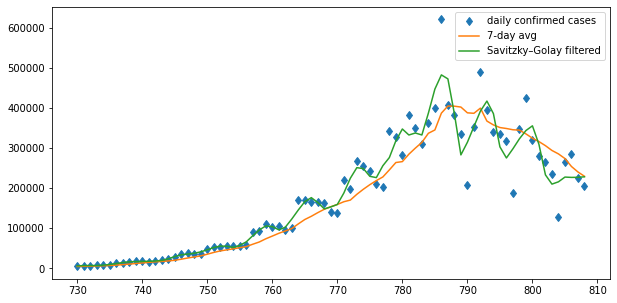

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df.counts[730:], 'd', label="daily confirmed cases")
df.rolling_avg[730:].plot(label="7-day avg")
df.savgol[730:].plot(label="Savitzky–Golay filtered")
plt.legend()

## skewed normal fifting using original data

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 152
    # data points      = 44
    # variables        = 4
    chi-square         = 1.9635e+11
    reduced chi-square = 4.9087e+09
    Akaike info crit   = 985.634652
    Bayesian info crit = 992.771411
[[Variables]]
    amplitude:  15286995.2 +/- 1041497.89 (6.81%) (init = 1.363930e+07)
    center:     24.1477484 +/- 53513.1461 (221607.19%) (init = 102.12)
    sigma:      15.9767420 +/- 673.989178 (4218.56%) (init = 22.41)
    gamma:     -0.01579871 +/- 4199.11539 (26578843.05%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, gamma)  = 0.383
    C(amplitude, center) = -0.383
    C(amplitude, sigma)  = -0.382


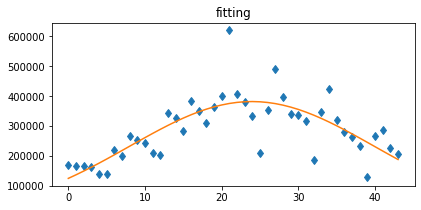

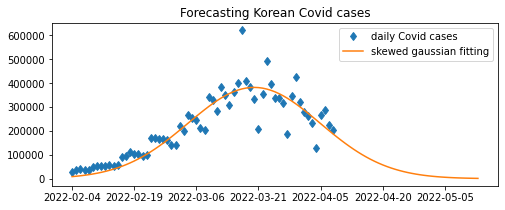

In [5]:
target_y = df.counts
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 158
    # data points      = 44
    # variables        = 4
    chi-square         = 1.1124e+15
    reduced chi-square = 2.7811e+13
    Akaike info crit   = 1365.89034
    Bayesian info crit = 1373.02710
[[Variables]]
    amplitude:  15389837.5 +/- 1070146.91 (6.95%) (init = 1.363930e+07)
    center:     23.9935035 +/- 252717.727 (1053275.64%) (init = 102.12)
    sigma:      16.1422252 +/- 774.287832 (4796.66%) (init = 22.41)
    gamma:     -0.00384089 +/- 19621.8396 (510866668.33%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma) = -1.000
    C(sigma, gamma)  = -1.000
    C(center, sigma) = 1.000


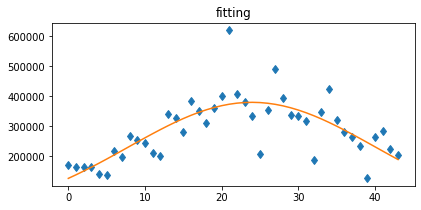

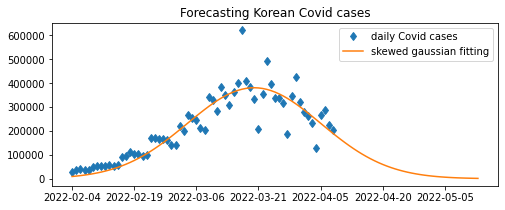

In [6]:
target_y = df.counts
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)
plt.savefig("./figs/fitting_n_prediction.png", facecolor="w")

## skewed normal fifting using 7-day rolling avg

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 42
    # variables        = 4
    chi-square         = 1.1099e+10
    reduced chi-square = 2.9208e+08
    Akaike info crit   = 822.482728
    Bayesian info crit = 829.433407
[[Variables]]
    amplitude:  14899083.7 +/- 304518.133 (2.04%) (init = 1.363930e+07)
    center:     38.3916249 +/- 1.40636923 (3.66%) (init = 102.12)
    sigma:      20.8585223 +/- 1.52087336 (7.29%) (init = 22.41)
    gamma:     -1.40385252 +/- 0.40700201 (28.99%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.984
    C(sigma, gamma)      = -0.950
    C(center, gamma)     = -0.950
    C(amplitude, gamma)  = 0.488
    C(amplitude, center) = -0.256
    C(amplitude, sigma)  = -0.230


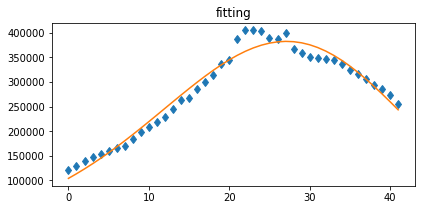

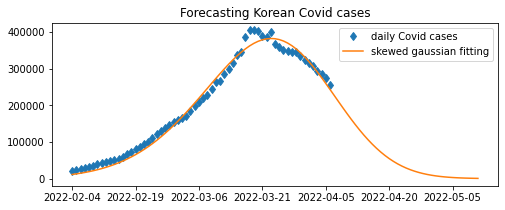

In [7]:
target_y = df.rolling_avg
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 42
    # variables        = 4
    chi-square         = 5.5157e+13
    reduced chi-square = 1.4515e+12
    Akaike info crit   = 1179.94846
    Bayesian info crit = 1186.89914
[[Variables]]
    amplitude:  14990806.6 +/- 292930.926 (1.95%) (init = 1.363930e+07)
    center:     36.2639209 +/- 3.65697199 (10.08%) (init = 102.12)
    sigma:      18.9675718 +/- 2.64730626 (13.96%) (init = 22.41)
    gamma:     -0.95995867 +/- 0.57224786 (59.61%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -0.995
    C(center, sigma)     = 0.994
    C(sigma, gamma)      = -0.986
    C(amplitude, gamma)  = 0.371
    C(amplitude, center) = -0.307
    C(amplitude, sigma)  = -0.228


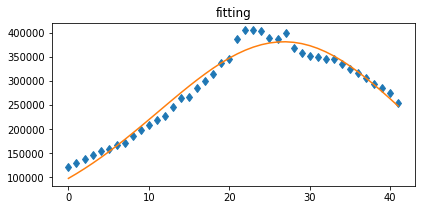

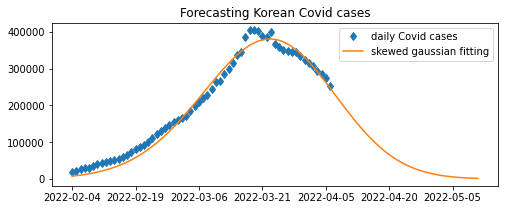

In [8]:
target_y = df.rolling_avg
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)

## skewed normal fifting using Savitzky–Golay filtered signal

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 226
    # data points      = 42
    # variables        = 4
    chi-square         = 7.9492e+10
    reduced chi-square = 2.0919e+09
    Akaike info crit   = 905.172685
    Bayesian info crit = 912.123364
[[Variables]]
    amplitude:  15139553.8 +/- 788203.346 (5.21%) (init = 1.363930e+07)
    center:     23.8270893 +/- 49017.5401 (205721.90%) (init = 102.12)
    sigma:      15.7783050 +/- 548.404217 (3475.69%) (init = 22.41)
    gamma:     -0.00138211 +/- 3894.25301 (281760598.01%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, gamma)  = 0.528
    C(amplitude, center) = -0.528
    C(amplitude, sigma)  = -0.527


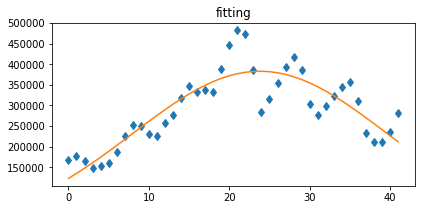

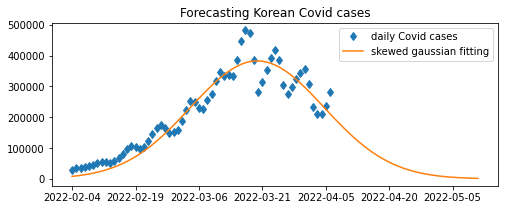

In [9]:
target_y = df.savgol
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 159
    # data points      = 42
    # variables        = 4
    chi-square         = 4.4173e+14
    reduced chi-square = 1.1624e+13
    Akaike info crit   = 1267.33008
    Bayesian info crit = 1274.28075
[[Variables]]
    amplitude:  15187500.0 +/- 750059.592 (4.94%) (init = 1.363930e+07)
    center:     23.8586571 +/- 240532.236 (1008154.97%) (init = 102.12)
    sigma:      15.8544740 +/- 694.588514 (4381.03%) (init = 22.41)
    gamma:     -0.00362036 +/- 19014.6412 (525213824.04%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, center) = -0.227
    C(amplitude, gamma)  = 0.227
    C(amplitude, sigma)  = -0.226


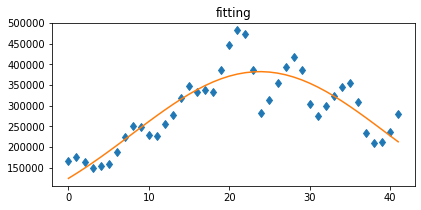

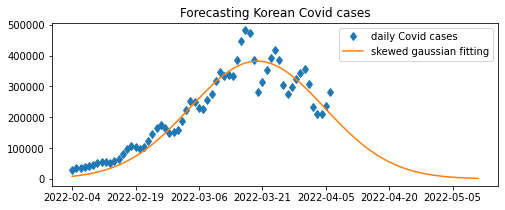

In [10]:
target_y = df.savgol
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)